In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_ENABLE_X64"] = "True"

import lagrangebench
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation

2024-01-12 16:47:34.872366: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
ldc2d_train = lagrangebench.data.LDC2D("train", extra_seq_length=5)  # extra_seq_length=5 will be clear later
ldc2d_valid = lagrangebench.data.LDC2D("valid", extra_seq_length=20)

print(
    f"This is a {ldc2d_train.metadata['dim']}D dataset "
    f"called {ldc2d_train.metadata['case']}.\n"
    f"Train snapshot have shape {ldc2d_train[0][0].shape} (n_nodes, seq_len, xy pos).\n"
    f"Val snapshot have shape {ldc2d_valid[0][0].shape} (n_nodes, rollout, xy pos).\n"
)

This is a 2D dataset called HT.
Train snapshot have shape (950, 12, 2) (n_nodes, seq_len, xy pos).
Val snapshot have shape (950, 26, 2) (n_nodes, rollout, xy pos).



In [3]:
def gns(x):
    return lagrangebench.GNS(
        particle_dimension=ldc2d_train.metadata["dim"],
        latent_size=16,
        blocks_per_step=2,
        num_mp_steps=4,
        particle_type_embedding_size=8,
    )(x)

In [4]:
gns = hk.without_apply_rng(hk.transform_with_state(gns))

In [5]:
noise_std = 3e-4

pf_config = lagrangebench.PushforwardConfig(
    steps=[-1, 500, 700],  # training steps to unlock the relative stage
    unrolls=[0, 2, 5],  # number of unroll steps per stage
    probs=[7, 2, 1],  # relative probabilities to unroll to the relative stage
)

In [6]:
bounds = np.array(ldc2d_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

ldc2d_case = lagrangebench.case_builder(
    box=box,  # (x,y) array with the world size along each axis. (1.0, 1.0) for 2D ldc
    metadata=ldc2d_train.metadata,  # metadata dictionary
    input_seq_length=6,  # number of consecutive time steps fed to the model
    isotropic_norm=False,  # whether to normalize each dimension independently
    noise_std=noise_std,  # noise standard deviation used by the random-walk noise
)

In [7]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=ldc2d_case,
    data_train=ldc2d_train,
    data_valid=ldc2d_valid,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=100,
    eval_steps=500,
    batch_size_infer=1,
)

params, state, _ = trainer(step_max=1000)

/home/uppili11/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


0000, train/loss: 4.71329.
0100, train/loss: 1.37900.
0200, train/loss: 1.23552.
0300, train/loss: 1.06469.
0400, train/loss: 1.09993.
0500, train/loss: 1.21956.
{'val/loss': 1.5301642968473132e-05, 'val/mse1': 2.2160388053611312e-08, 'val/mse10': 2.6194562609788967e-06, 'val/mse5': 7.012238003540277e-07, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse10': 0.0, 'val/stdmse5': 0.0}
0600, train/loss: 0.23481.
0700, train/loss: 0.92820.
0800, train/loss: 0.92873.
0900, train/loss: 0.86081.
1000, train/loss: 0.20520.
{'val/loss': 8.16456144046693e-06, 'val/mse1': 1.955856163526193e-08, 'val/mse10': 1.7598202060033546e-06, 'val/mse5': 5.742900581500797e-07, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse10': 0.0, 'val/stdmse5': 0.0}


In [9]:
ldc2d_test = lagrangebench.LDC2D("test", extra_seq_length=20)

In [10]:
metrics = lagrangebench.infer(
    gns,
    ldc2d_case,
    ldc2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
    batch_size=1,
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

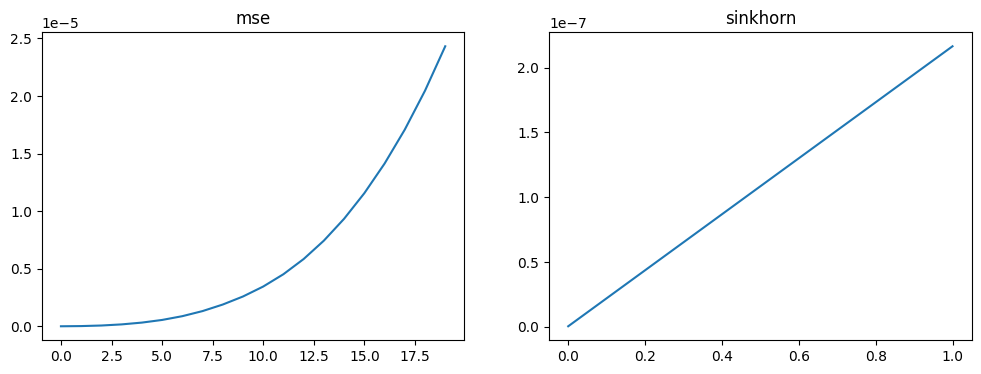

In [11]:
# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [12]:
print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter4.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter4.gif")

rollout of shape (26, 950, 2) (steps, nodes, xy pos)


In [28]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=ldc2d_case,
    data_train=ldc2d_train,
    data_valid=ldc2d_valid,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=500,
    eval_steps=2500,
    batch_size_infer=1,
)

params, state, _ = trainer(step_max=5000)

0000, train/loss: 1.64200.
0500, train/loss: 0.07422.
Reallocate neighbors list at step 618
From (2, 8098) to (2, 8063)
Reallocate neighbors list at step 630
From (2, 8063) to (2, 8118)
1000, train/loss: 0.09015.
Reallocate neighbors list at step 1440
From (2, 8118) to (2, 8098)
Reallocate neighbors list at step 1448
From (2, 8098) to (2, 8036)
Reallocate neighbors list at step 1473
From (2, 8036) to (2, 8098)
1500, train/loss: 0.21223.
Reallocate neighbors list at step 1648
From (2, 8098) to (2, 7948)
Reallocate neighbors list at step 1824
From (2, 7948) to (2, 7996)
Reallocate neighbors list at step 1945
From (2, 7996) to (2, 8096)
2000, train/loss: 0.02419.
Reallocate neighbors list at step 2246
From (2, 8096) to (2, 8016)
2500, train/loss: 0.07301.
(eval) Reallocate neighbors list at step 3
(eval) From (2, 8016) to (2, 8221)
{'val/loss': 6.098418789396154e-05, 'val/mse1': 5.651146235914734e-06, 'val/mse10': 3.3380296873077285e-05, 'val/mse5': 2.763932436695676e-05, 'val/stdloss': 0

In [ ]:
ldc2d_test = lagrangebench.LDC2D("test", extra_seq_length=20)

In [ ]:
metrics = lagrangebench.infer(
    gns,
    ldc2d_case,
    ldc2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
    batch_size=1,
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

In [ ]:
# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [ ]:
print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter5.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter5.gif")

In [ ]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=ldc2d_case,
    data_train=ldc2d_train,
    data_valid=ldc2d_valid,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=1000,
    eval_steps=5000,
    batch_size_infer=1,
)

params, state, _ = trainer(step_max=10000)

In [ ]:
ldc2d_test = lagrangebench.LDC2D("test", extra_seq_length=20)

In [ ]:
metrics = lagrangebench.infer(
    gns,
    ldc2d_case,
    ldc2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
    batch_size=1,
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

In [ ]:
# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [ ]:
print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter6.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter6.gif")